# imports

In [3]:
# ! pip install seaborn

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import boto3
import json
import os 
import sagemaker
print(sagemaker.__version__)
import warnings
warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
2.215.0


In [3]:
import logging
logging.getLogger('Sagemaker').setLevel(logging.WARNING)


# DATA 
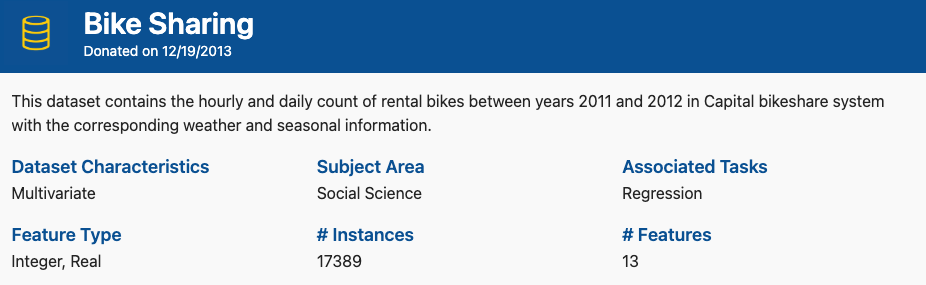

**Bike sharing systems** are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 


**url**: https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

**paper**: https://www.semanticscholar.org/paper/Event-labeling-combining-ensemble-detectors-and-Fanaee-T-Gama/bc42899f599d31a5d759f3e0a3ea8b52479d6423

# get sakemaker domain id

In [3]:
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        # print(json.loads(f.read()))
        domain_id = json.loads(f.read()).get('DomainId')
        print(f"SageMaker domain id: {domain_id}")

SageMaker domain id: d-d5bg3f61fx3f


# get s3 bucket details 

In [4]:
boto_session = boto3.Session()
region = boto_session.region_name
print(f"Region--{region}")
sm_role = sagemaker.get_execution_role()
print(f"Sagemaker Role--{sm_role}")
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
print(f"Default bucket--{default_bucket}")

Region--eu-north-1
Sagemaker Role--arn:aws:iam::058264393695:role/service-role/AmazonSageMaker-ExecutionRole-20240621T001438
Default bucket--sagemaker-eu-north-1-058264393695


In [5]:
s3_client = boto3.client("s3")
# retrieve bucket information
bucket_info = s3_client.get_bucket_location(Bucket=default_bucket)
print(bucket_info)
# retrieve the bucket objects 
objects = s3_client.list_objects_v2(Bucket=default_bucket)
for obj in objects.get('Contents', []):
    print(obj['Key'])

{'ResponseMetadata': {'RequestId': '4X63AAAHXW7PH0P5', 'HostId': 'UardbweZRf94JcCJdc40WAqBVzNZz4XKKlgBdDhzG8LA02HF8Ht0nmid+Zwb7TpmbtS6cuIZ1YI=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'UardbweZRf94JcCJdc40WAqBVzNZz4XKKlgBdDhzG8LA02HF8Ht0nmid+Zwb7TpmbtS6cuIZ1YI=', 'x-amz-request-id': '4X63AAAHXW7PH0P5', 'date': 'Sat, 22 Jun 2024 06:13:45 GMT', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'LocationConstraint': 'eu-north-1'}
bits-webminar-june-24/bike-sharing-dataset.csv
bits-webminar-june-24/test_data.csv
bits-webminar-june-24/train_data.csv
bits-webminar-june-24/validation_data.csv
container-processing-2024-06-22-05-19-50-659/input/code/preprocessing.py
container-processing-2024-06-22-05-33-56-589/input/code/preprocessing.py


In [5]:
# bucket_prefix = "siemens-poc/"
!aws s3 ls {bucket_name}/{bucket_prefix} --recursive


Parameter validation failed:
Invalid bucket name "{bucket_name}": Bucket name must match the regex "^[a-zA-Z0-9.\-_]{1,255}$" or be an ARN matching the regex "^arn:(aws).*:(s3|s3-object-lambda):[a-z\-0-9]*:[0-9]{12}:accesspoint[/:][a-zA-Z0-9\-.]{1,63}$|^arn:(aws).*:s3-outposts:[a-z\-0-9]+:[0-9]{12}:outpost[/:][a-zA-Z0-9\-]{1,63}[/:]accesspoint[/:][a-zA-Z0-9\-]{1,63}$"


# set constants


In [8]:
bucket_name = default_bucket
initialized = True

In [9]:
import os
import yaml

yaml_path = os.path.abspath(os.path.join(os.pardir, 'config.yml')) 
with open(yaml_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
print(config)

# Update config values
config['sagemaker']['role'] = sm_role 
config['sagemaker']['region'] = region
config['sagemaker']['domain_id'] = domain_id
config['s3-bucket']['bucket_name'] = bucket_name
config['s3-bucket']['bucket_prefix'] = bucket_prefix

with open(yaml_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)
print(config)

{'features': ['dteday', 'season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'yr', 'mnth'], 'hr_mappings': {'10am': 9, '10pm': 8, '11am': 11, '11pm': 7, '12am': 5, '12pm': 17, '1am': 4, '1pm': 16, '2am': 3, '2pm': 15, '3am': 1, '3pm': 18, '4am': 0, '4pm': 19, '5am': 2, '5pm': 23, '6am': 6, '6pm': 22, '7am': 12, '7pm': 20, '8am': 21, '8pm': 14, '9am': 13, '9pm': 10}, 'mnth_mappings': {'April': 5, 'August': 11, 'December': 2, 'February': 1, 'January': 0, 'July': 10, 'June': 9, 'March': 3, 'May': 7, 'November': 4, 'October': 6, 'September': 8}, 's3-bucket': {'bucket_name': 'sagemaker-us-east-1-644383320443', 'bucket_prefix': 'siemens-poc/', 'training_file_key': 'siemens-poc/bike-sharing-dataset.csv'}, 'sagemaker': {'domain_id': 'd-zjfao8azi0ng', 'region': 'us-east-1', 'role': 'arn:aws:iam::644383320443:role/service-role/AmazonSageMaker-ExecutionRole-20240109T220483'}, 'season_mappings': {'fall': 3, 'spring': 0, 'sum

In [10]:
# Store  variables to keep the value between the notebooks
%store bucket_name
%store sm_role
%store region
%store initialized
%store domain_id

Stored 'bucket_name' (str)
Stored 'sm_role' (str)
Stored 'region' (str)
Stored 'initialized' (bool)
Stored 'domain_id' (str)


# read data from s3

In [7]:
default_bucket

'sagemaker-eu-north-1-058264393695'

In [9]:
import io
file_key  = 'bits-webminar-june-24/bike-sharing-dataset.csv'

response = s3_client.get_object(Bucket=default_bucket, Key=file_key)
file_content = response['Body'].read()
df = pd.read_csv(io.BytesIO(file_content), encoding='utf-8')
df.head(3)


,dteday,season,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2012-11-05,winter,6am,No,Mon,Yes,Mist,6.10,3.0014,49.0,19.0012,4,135,139
1,2011-07-13,fall,4am,No,Wed,Yes,Clear,26.78,28.9988,58.0,16.9979,0,5,5
2,2012-02-09,spring,11am,No,Thu,Yes,Clear,3.28,-0.9982,52.0,15.0013,4,95,99


# Exploratory data analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  object 
 2   hr          17379 non-null  object 
 3   holiday     17379 non-null  object 
 4   weekday     16504 non-null  object 
 5   workingday  17379 non-null  object 
 6   weathersit  16121 non-null  object 
 7   temp        17379 non-null  float64
 8   atemp       17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  casual      17379 non-null  int64  
 12  registered  17379 non-null  int64  
 13  cnt         17379 non-null  int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 1.9+ MB


In [10]:
 # Working on `dteday` column to extract year and month
def get_year_and_month(dataframe):
    df = dataframe.copy()
    # convert 'dteday' column to Datetime datatype
    df['dteday'] = pd.to_datetime(df['dteday'], format='%Y-%m-%d')
    # Add new features 'yr' and 'mnth
    df['yr'] = df['dteday'].dt.year
    df['mnth'] = df['dteday'].dt.month_name()
    return df

In [11]:
df = get_year_and_month(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  object        
 2   hr          17379 non-null  object        
 3   holiday     17379 non-null  object        
 4   weekday     16504 non-null  object        
 5   workingday  17379 non-null  object        
 6   weathersit  16121 non-null  object        
 7   temp        17379 non-null  float64       
 8   atemp       17379 non-null  float64       
 9   hum         17379 non-null  float64       
 10  windspeed   17379 non-null  float64       
 11  casual      17379 non-null  int64         
 12  registered  17379 non-null  int64         
 13  cnt         17379 non-null  int64         
 14  yr          17379 non-null  int32         
 15  mnth        17379 non-null  object        
dtypes: datetime64[ns](1), 

In [12]:
# find numerical and categorical variables
unused_colms = ['dteday', 'casual', 'registered']   # unused columns will be removed at later stage
target_col = ['cnt']

numerical_features = []
categorical_features = []

for col in df.columns:
    if col not in target_col + unused_colms:
        if df[col].dtypes == 'float64':
            numerical_features.append(col)
        else:
            categorical_features.append(col)


print('Number of numerical variables: {}'.format(len(numerical_features)),":" , numerical_features)

print('Number of categorical variables: {}'.format(len(categorical_features)),":" , categorical_features)

Number of numerical variables: 4 : ['temp', 'atemp', 'hum', 'windspeed']
Number of categorical variables: 8 : ['season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'yr', 'mnth']


## missing values

In [11]:
# numerical variables
df[numerical_features].isnull().sum()

temp         0
atemp        0
hum          0
windspeed    0
dtype: int64

In [12]:
# categorical variables
df[categorical_features].isnull().sum()

season           0
hr               0
holiday          0
weekday        875
workingday       0
weathersit    1258
yr               0
mnth             0
dtype: int64

In [13]:
# cardinality of categorical variables
# Count of unique values
df[categorical_features].nunique()

season         4
hr            24
holiday        2
weekday        7
workingday     2
weathersit     4
yr             2
mnth          12
dtype: int64

<Axes: xlabel='windspeed', ylabel='Count'>

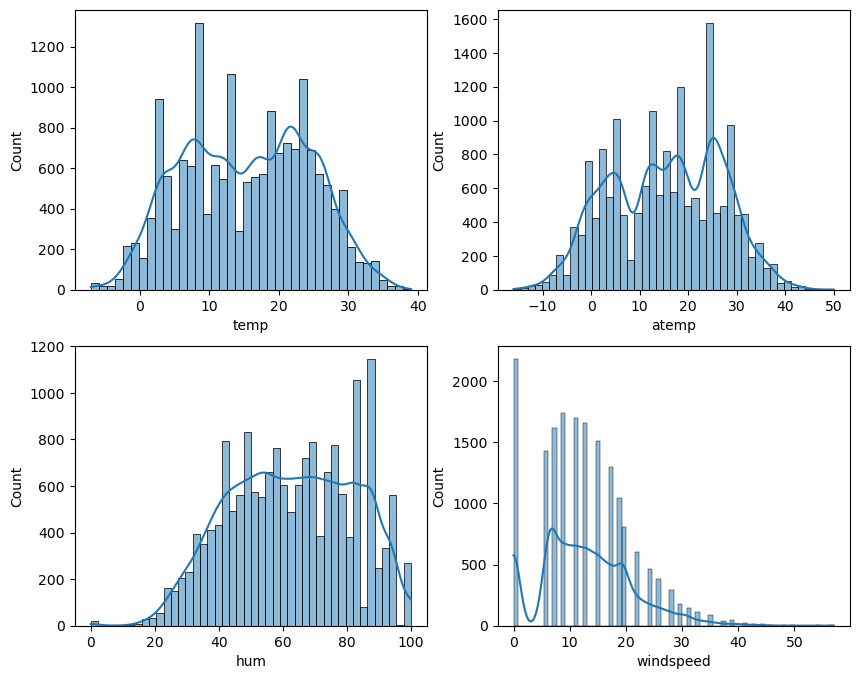

In [14]:
# distribution of numerical features
# Visualize distribution using histplot
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(ax = ax[0, 0], x = df[numerical_features[0]], kde=True)
sns.histplot(ax = ax[0, 1], x = df[numerical_features[1]], kde=True)
sns.histplot(ax = ax[1, 0], x = df[numerical_features[2]], kde=True)
sns.histplot(ax = ax[1, 1], x = df[numerical_features[3]], kde=True)

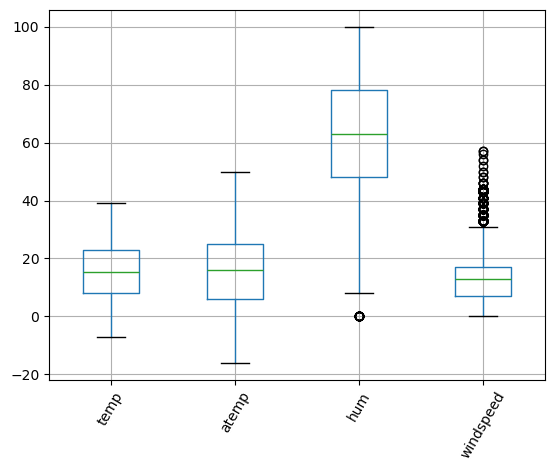

In [15]:
# outliers in continuous features
df[numerical_features].boxplot()
plt.xticks(rotation= 60)
plt.show()

In [16]:
# Group the dataset w.r.t hour
grouped_by_hr = df.groupby('hr').sum('cnt')
grouped_by_hr.head()

,temp,atemp,hum,windspeed,casual,registered,cnt,yr
hr,,,,,,,,
10am,11288.24,11310.0422,44788.0,9841.2079,33789,92468,126257,1462361
10pm,10753.84,10768.0750,47549.0,8518.2594,16200,79412,95612,1464373
11am,12041.18,12237.9494,41543.0,10099.2785,43286,108034,151320,1462361
11pm,10429.54,10362.1354,49014.0,8038.3920,11065,52876,63941,1464373
12am,10140.98,9999.1320,50168.0,7868.2522,7375,31755,39130,1460351


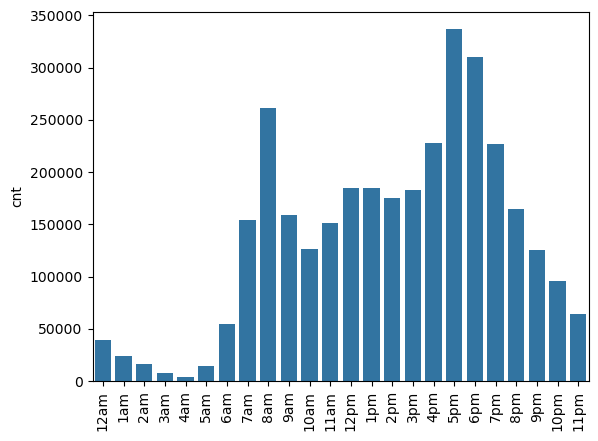

In [17]:
#  total bike rental count for per hour

hour_sequence = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am',
                 '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm', '11pm']

sns.barplot(x = hour_sequence, y = grouped_by_hr.loc[hour_sequence, 'cnt'])
plt.xticks(rotation=90)
plt.show()

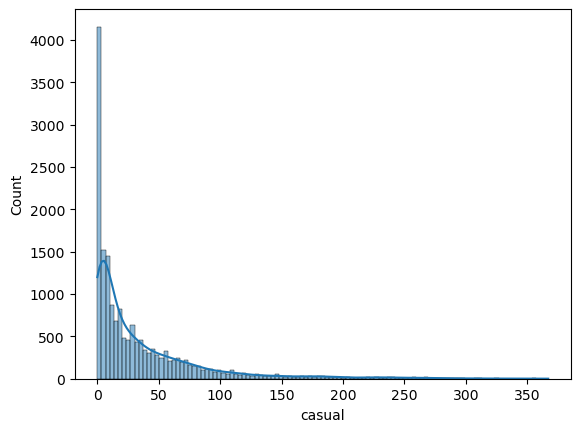

In [18]:
# distribution of casual rentals
sns.histplot(df['casual'], kde=True);
plt.show()

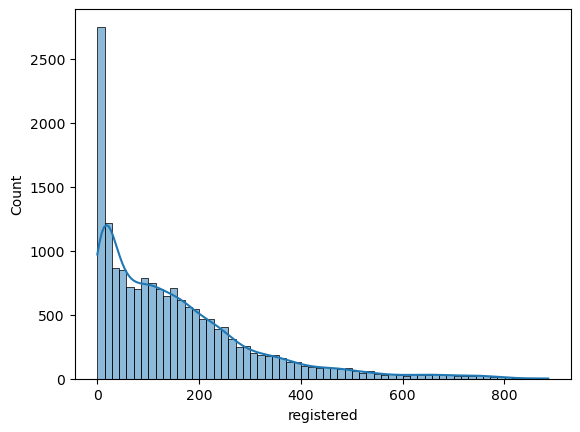

In [19]:
# distribution of registered retals
sns.histplot(df['registered'], kde=True);

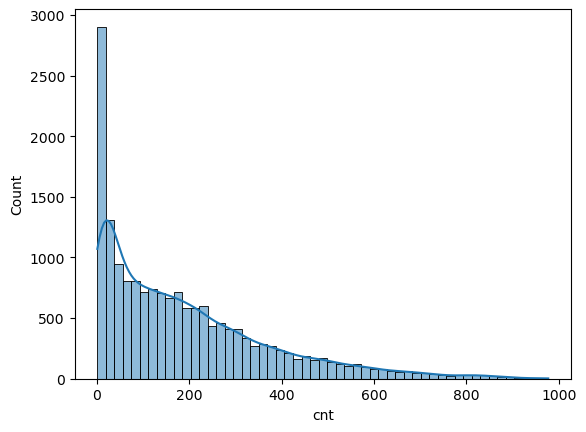

In [20]:
# distribution of count ( target variable )
sns.histplot(df['cnt'], kde=True);

In [21]:
# Unique values of 'workingday'
df['workingday'].unique()

array(['Yes', 'No'], dtype=object)

In [22]:
# Check which weekdays are working days (Mon - Fri)
df[df.workingday=='Yes'].weekday.unique()

array(['Mon', 'Wed', 'Thu', 'Tue', 'Fri', nan], dtype=object)

In [23]:
# Check on which weekdays, holiday is possible
df[df.holiday=='Yes'].weekday.unique()

array(['Mon', 'Fri', 'Thu', nan, 'Tue', 'Wed'], dtype=object)

In [24]:
# Not a holiday, not a working day (Sat, Sun)
df[(df.holiday=='No') & (df.workingday=='No')].weekday.unique()

array([nan, 'Sun', 'Sat'], dtype=object)

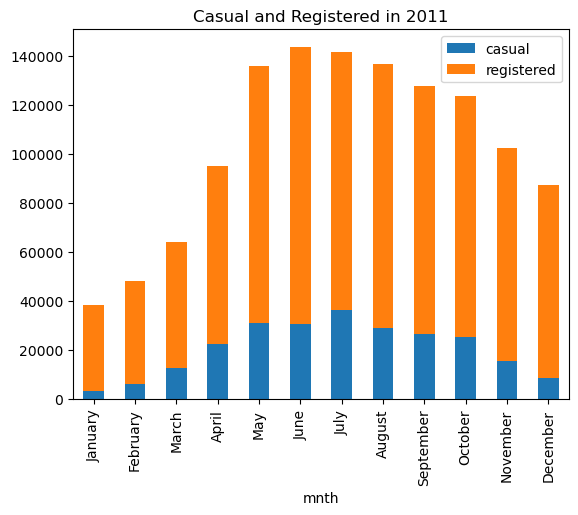

In [25]:
# month  wise count of both casual and registered rentals for the year 2011 and 2012 
mnth_sequence = ['January', 'February', 'March', 'April', 'May', 'June',
                 'July', 'August', 'September', 'October', 'November', 'December']

grouped_by_mnth = df[df.yr==2011].groupby('mnth').sum(['casual','registered'])

grouped_by_mnth.loc[mnth_sequence, ['casual','registered']].plot.bar(stacked=True);
plt.title("Casual and Registered in 2011")
plt.show()

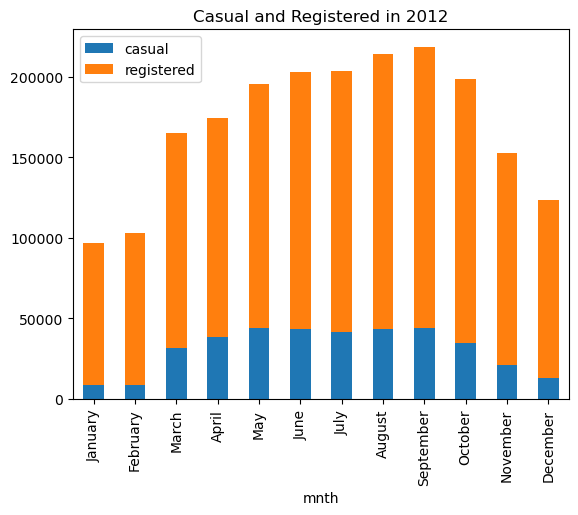

In [26]:
grouped_by_mnth = df[df.yr==2012].groupby('mnth').sum(['casual','registered'])
grouped_by_mnth.loc[mnth_sequence, ['casual','registered']].plot.bar(stacked=True);
plt.title("Casual and Registered in 2012")
plt.show()

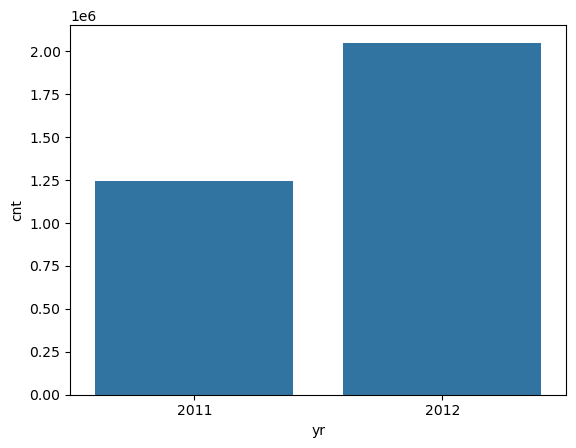

In [27]:
# Visualize the total bike rental count per year
feature = 'yr'
grouped_by_yr = df.groupby(feature).sum('cnt')
sns.barplot(x = grouped_by_yr.index, y = grouped_by_yr['cnt'])
plt.show()

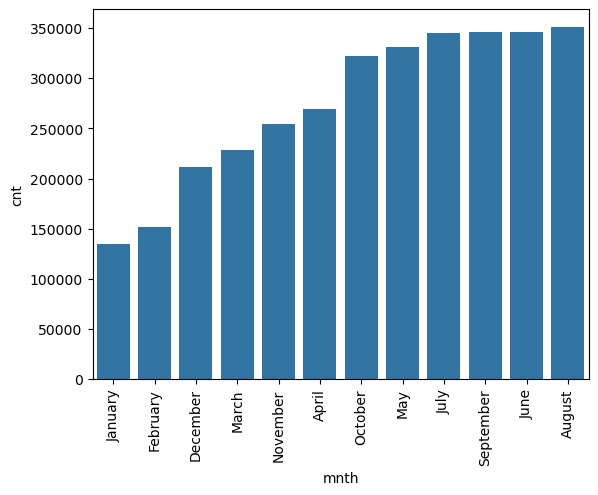

In [28]:
# Visualize the total bike rental count per month
feature = 'mnth'
grouped_by_mnth = df.groupby(feature).sum('cnt').sort_values('cnt')
sns.barplot(x = grouped_by_mnth.index, y = grouped_by_mnth['cnt'])
plt.xticks(rotation=90)
plt.show()

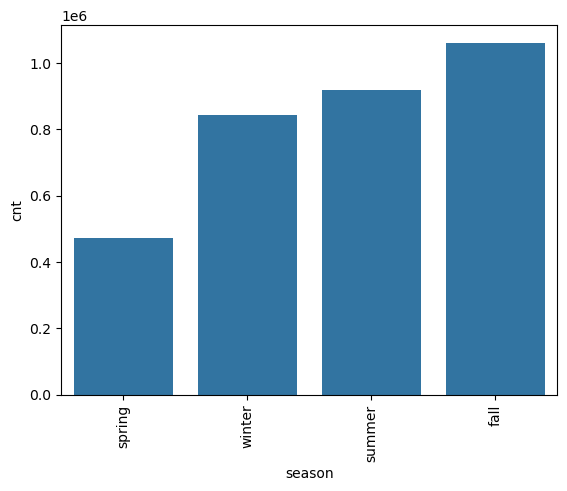

In [29]:
# Visualize the total bike rental count per season
feature = 'season'
grouped_by_season = df.groupby(feature).sum('cnt').sort_values('cnt')
sns.barplot(x = grouped_by_season.index, y = grouped_by_season['cnt'])
plt.xticks(rotation=90)
plt.show()

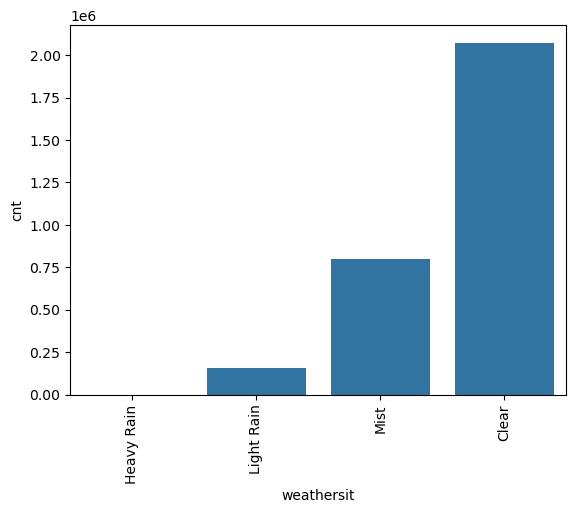

In [30]:
# Visualize the total bike rental count per weather situation
feature = 'weathersit'
grouped_by_weather = df.groupby(feature).sum('cnt').sort_values('cnt')
sns.barplot(x = grouped_by_weather.index, y = grouped_by_weather['cnt'])
plt.xticks(rotation=90)
plt.show()

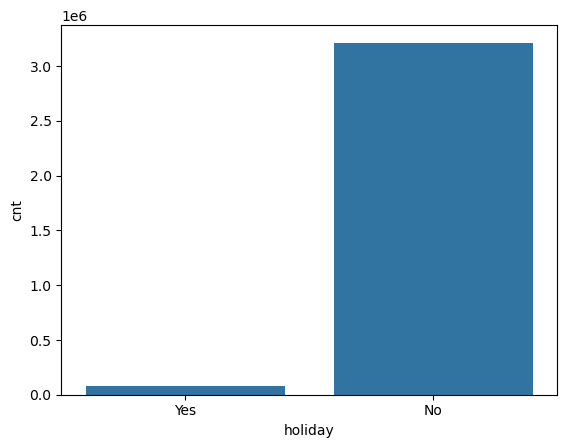

In [31]:
# Visualize the total bike rental count based on whether the day is holiday
feature = 'holiday'
grouped_by_holiday = df.groupby(feature).sum('cnt').sort_values('cnt')
sns.barplot(x = grouped_by_holiday.index, y = grouped_by_holiday['cnt'])
plt.show()

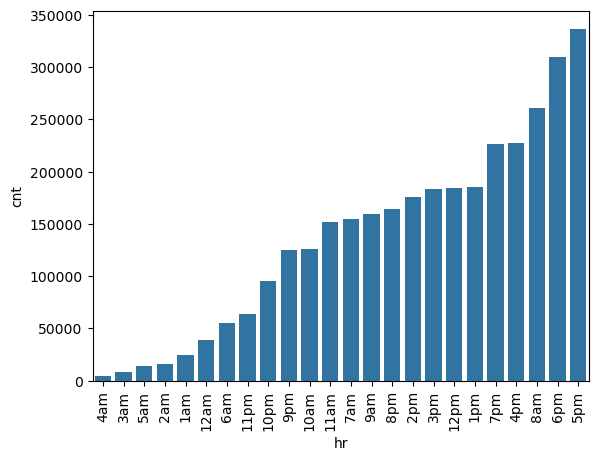

In [32]:
# Visualize the total bike rental count per hour
feature = 'hr'
grouped_by_hr = df.groupby(feature).sum('cnt').sort_values('cnt')
sns.barplot(x = grouped_by_hr.index, y = grouped_by_hr['cnt'])
plt.xticks(rotation=90)
plt.show()

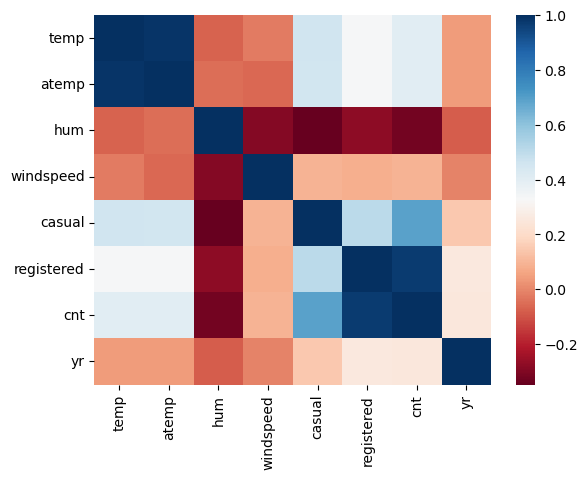

In [33]:
# correlation between features with heatmap
sns.heatmap(df.iloc[:,:].corr(numeric_only=True), cmap='RdBu')
plt.show()

# Data preprocessig

In [13]:
# Function to impute weekday by extracting day name from the date column

def impute_weekday(dataframe):
    df = dataframe.copy()
    wkday_null_idx = df[df['weekday'].isnull() == True].index
    # print(len(wkday_null_idx))
    df.loc[wkday_null_idx, 'weekday'] = df.loc[wkday_null_idx, 'dteday'].dt.day_name().apply(lambda x: x[:3])
    return df

In [14]:
# Function to handle outliers for a single column

def handle_outliers(dataframe, colm):
    df = dataframe.copy()
    q1 = df.describe()[colm].loc['25%']
    q3 = df.describe()[colm].loc['75%']
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in df.index:
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

In [15]:
# Treating 'yr' column as Ordinal categorical variable, assign higher value to 2012
yr_mapping = {2011: 0, 2012: 1}
# Treat 'mnth' column as Ordinal categorical variable, and assign values accordingly
mnth_mapping = {'January': 0, 'February': 1, 'December': 2, 'March': 3, 'November': 4, 'April': 5,
                'October': 6, 'May': 7, 'September': 8, 'June': 9, 'July': 10, 'August': 11}
# Treat 'season' column as Ordinal categorical variable, and assign values accordingly
season_mapping = {'spring': 0, 'winter': 1, 'summer': 2, 'fall': 3}
# Map weather situation
weather_mapping = {'Heavy Rain': 0, 'Light Rain': 1, 'Mist': 2, 'Clear': 3}
# Map holiday
holiday_mapping = {'Yes': 0, 'No': 1}
# Map workingday
workingday_mapping = {'No': 0, 'Yes': 1}
# Map hour
hour_mapping = {'4am': 0, '3am': 1, '5am': 2, '2am': 3, '1am': 4, '12am': 5, '6am': 6, '11pm': 7, '10pm': 8,
                '10am': 9, '9pm': 10, '11am': 11, '7am': 12, '9am': 13, '8pm': 14, '2pm': 15, '1pm': 16,
                '12pm': 17, '3pm': 18, '4pm': 19, '7pm': 20, '8am': 21, '6pm': 22, '5pm': 23}

In [16]:
df['hr'].value_counts()

hr
4pm     730
5pm     730
1pm     729
3pm     729
2pm     729
12pm    728
9pm     728
8pm     728
11pm    728
6pm     728
10pm    728
7pm     728
11am    727
7am     727
8am     727
9am     727
10am    727
12am    726
6am     725
1am     724
5am     717
2am     715
4am     697
3am     697
Name: count, dtype: int64

In [17]:
unused_colms.append('weekday')
unused_colms

['dteday', 'casual', 'registered', 'weekday']

In [18]:
# Treating 'weekday' column as a Nominal categorical variable, perform one-hot encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# build encoder
encoder = OneHotEncoder(sparse_output=False)


In [19]:
## Function for pre-processing the dataset

def pre_process(dataframe):
    df = dataframe.copy()
    df = impute_weekday(df)
    df['weathersit'].fillna('Clear', inplace=True)
    for col in numerical_features:
        df = handle_outliers(df, col)
    df['yr'] = df['yr'].apply(lambda x: yr_mapping[x])
    df['mnth'] = df['mnth'].apply(lambda x: mnth_mapping[x])
    df['season'] = df['season'].apply(lambda x: season_mapping[x])
    df['weathersit'] = df['weathersit'].apply(lambda x: weather_mapping[x])
    df['holiday'] = df['holiday'].apply(lambda x: holiday_mapping[x])
    df['workingday'] = df['workingday'].apply(lambda x: workingday_mapping[x])
    df['hr'] = df['hr'].apply(lambda x: hour_mapping[x])
    encoder.fit(df[['weekday']])
    enc_wkday_features = encoder.get_feature_names_out(['weekday'])
    encoded_weekday = encoder.transform(df[['weekday']])
    df[enc_wkday_features] = encoded_weekday
    # drop not required columns
    df.drop(labels = unused_colms, axis = 1, inplace = True)
    return df


In [24]:
encoder = OneHotEncoder()
encoder.fit(df[['weekday']])
enc_wkday_features = encoder.get_feature_names_out(['weekday'])
enc_wkday_features

array(['weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'weekday_nan'],
      dtype=object)

In [20]:
processed_df = pre_process(df)

In [21]:
processed_df.head(5)

,season,hr,holiday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,yr,mnth,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,1,6,1,1,2,6.10,3.0014,49.0,19.0012,139,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3,0,1,1,3,26.78,28.9988,58.0,16.9979,5,0,10,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,11,1,1,3,3.28,-0.9982,52.0,15.0013,99,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,12,1,1,2,14.56,15.0002,100.0,6.0032,361,1,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,17,1,1,3,16.44,17.0000,52.0,8.9981,203,0,4,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
 # check for missing values 
 processed_df.isna().sum()

season         0
hr             0
holiday        0
workingday     0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
yr             0
mnth           0
weekday_Fri    0
weekday_Mon    0
weekday_Sat    0
weekday_Sun    0
weekday_Thu    0
weekday_Tue    0
weekday_Wed    0
dtype: int64

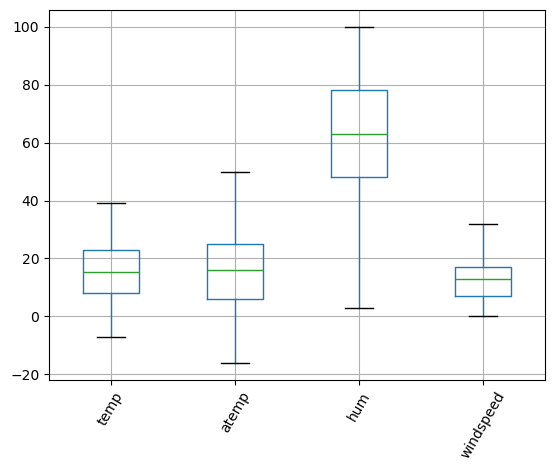

In [48]:
# check for outliers 
processed_df[numerical_features].boxplot()
plt.xticks(rotation= 60)
plt.show()

# Split the data

In [49]:
# Separate target and prediction features
X = processed_df.drop(target_col, axis=1)
y = processed_df[target_col]
X.shape, y.shape

((17379, 18), (17379, 1))

In [50]:
# Apply train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((13903, 18), (3476, 18))

# Data standardization

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled[0,:]

array([-0.47206567,  0.64468101,  0.17277688,  0.67638029,  0.66112249,
       -1.02829491, -1.18794399, -0.70689049,  1.43071367, -1.00151161,
       -1.02714193, -0.41026739, -0.40918992, -0.40895032, -0.40619057,
        2.47509377, -0.40811125, -0.41098503])

In [52]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled[0,:]

array([ 0.41881651,  0.35508489,  0.17277688, -1.47845821, -2.47379771,
       -0.71655971, -0.83494112,  1.57518148,  1.93558182,  0.99849067,
       -0.15887694, -0.41026739, -0.40918992, -0.40895032,  2.46189858,
       -0.4040251 , -0.40811125, -0.41098503])

In [53]:
# %store bucket_prefix

# shutdown kernel

In [18]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>



The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [19]:
import IPython

try:
    print(IPython.get_ipython().kernel.is_alive())
except AttributeError:
    print("Kernel shut down")

Kernel shut down
